## Import things

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Load images

read_pgm stolen from https://stackoverflow.com/questions/7368739/numpy-and-16-bit-pgm/7369986

In [2]:
import re

def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.

    Format specification: http://netpbm.sourceforge.net/doc/pgm.html

    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))


In [3]:
cover_images_path = "../data/raw/boss/cover"
hugo_images_path = "../data/raw/boss/stego"

[[126 125 127 ... 183 180 181]
 [124 122 123 ... 185 183 185]
 [121 118 119 ... 181 182 187]
 ...
 [106 109 112 ... 102 100 101]
 [107 108 109 ...  99  99 101]
 [105 104 105 ... 100 102 104]]


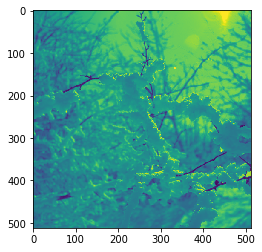

In [4]:
image = read_pgm(cover_images_path + "/150.pgm")
plt.imshow(image)
print(image)

In [5]:
cover_images = []
failed_cover = []

hugo_images = []
failed_hugo = []


percentage = .1

for i in tqdm(range(1, int(10001*percentage)+1)):
    try:
        image = read_pgm(cover_images_path + "/" + str(i) + ".pgm")
        cover_images.append(image)
    except:
        failed_cover.append(i)
        
for i in tqdm(range(1, int(10001*percentage)+1)):
    try:
        image = read_pgm(hugo_images_path + "/" + str(i) + ".pgm")
        hugo_images.append(image)
    except:
        failed_hugo.append(i)

100%|██████████| 1000/1000 [00:01<00:00, 869.05it/s]


In [6]:
print(len(failed_cover))
print(failed_cover)
print(len(failed_hugo))
print(failed_hugo)

3
[151, 439, 964]
2
[360, 964]


## Make usable datasets

In [7]:
# get same number in both sets
# TODO: these are not removing the same images in both

hugo_images.pop(0)
print(len(cover_images))
print(len(hugo_images))


997
997


In [8]:
split = .8

split_index = int(len(cover_images)*split)
rem_count = len(cover_images) - split_index

# make training data

# add cover images based on split
x_train = cover_images[0:split_index]
y_train = [0]*split_index

# add hugo images based on split
x_train.extend(hugo_images[0:split_index])
y_train.extend([1]*split_index)


# make test data

# add cover images based on split
x_test = cover_images[split_index:]
y_test = [0]*rem_count

# add hugo images based on split
x_test.extend(hugo_images[split_index:])
y_test.extend([1]*rem_count)


In [9]:
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))

1594 1594
400 400


randomization code stolen from https://tech.pic-collage.com/tips-of-numpy-shuffle-multiple-arrays-e4fb3e7ae2a

In [12]:
def randomize(a, b):
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]
    return shuffled_a, shuffled_b

In [13]:
# numpyify data
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

# shuffle training data
x_train, y_train = randomize(x_train, y_train)

# normalize data
x_train = x_train.astype("float32") / 255
x_test = x_train.astype("float32") / 255

In [14]:
# get the data into the right shape
w, h = 512, 512
x_train = x_train.reshape(x_train.shape[0], w, h, 1)
x_test = x_test.reshape(x_test.shape[0], w, h, 1)

# print shape information
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1594, 512, 512, 1)
(1594, 512, 512, 1)
(1594,)
(400,)


In [15]:
model = tf.keras.Sequential()

# Must define the input shape in the first layer of the neural network
model.add(tf.keras.layers.Conv2D(filters=2, kernel_size=2, padding='same', activation='relu', input_shape=(512,512,1)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=8))
model.add(tf.keras.layers.Dropout(0.3))

#model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
#model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
#model.add(tf.keras.layers.Dropout(0.3))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Take a look at the model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 512, 512, 2)       10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 2)         0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                81930     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total para

In [16]:
# compile model
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='model.weights.best', verbose=1, save_best_only=True)

model.fit(x_train, y_train, batch_size=1, epochs=10, callbacks=[checkpointer])

Using TensorFlow backend.


Epoch 1/10
1594/1594 [==============================] - 54s 34ms/step - loss: 0.2834 - acc: 0.4881
Epoch 2/10
   5/1594 [..............................] - ETA: 55s - loss: 0.2484 - acc: 0.8000   

/usr/lib/python3.7/site-packages/keras/callbacks.py:434: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


 581/1594 [=========>....................] - ETA: 33s - loss: 0.2497 - acc: 0.5336